# NYC Taxi Trip Time Prediction

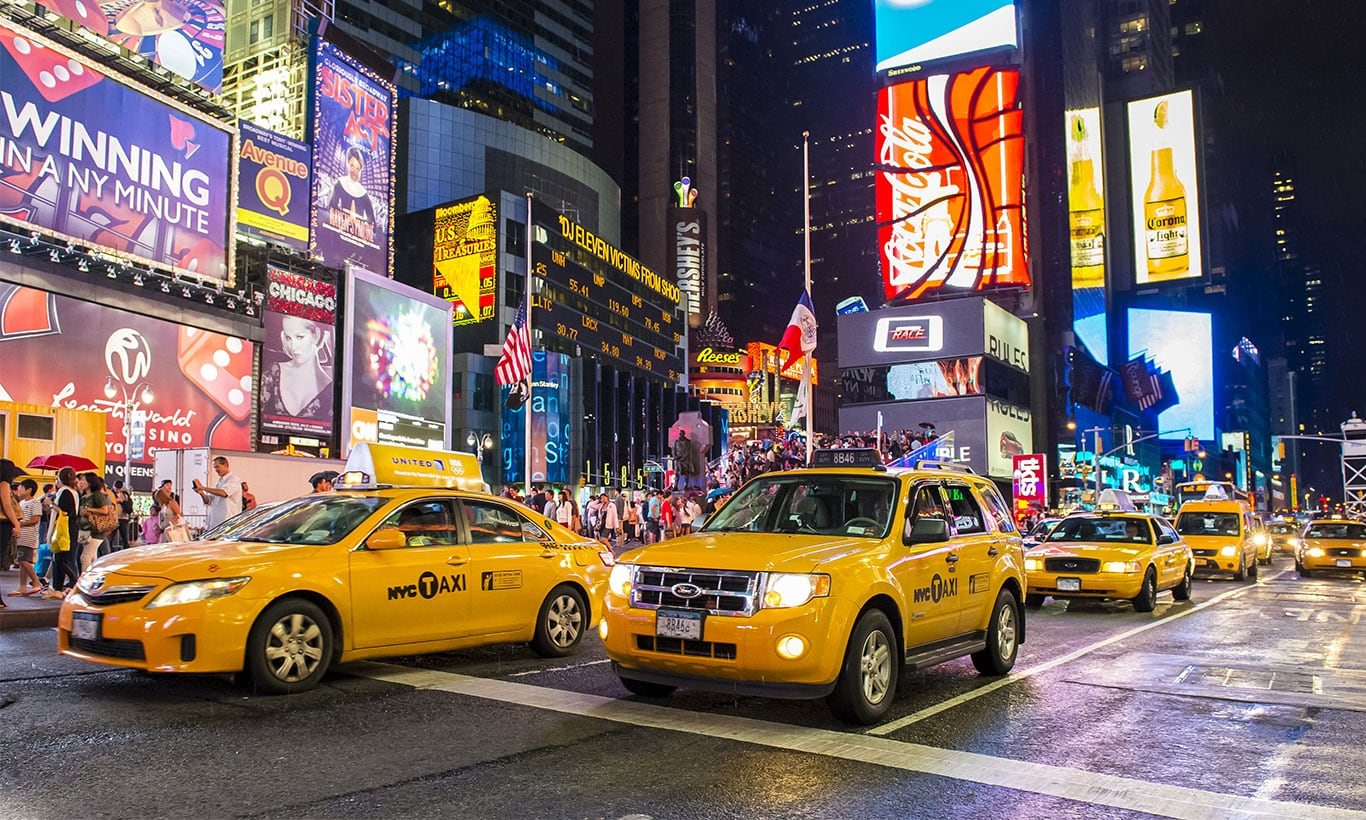

## Problem Statement

Given a dataset of taxi trip records in New York City, the goal is to develop a model that accurately predicts the total trip duration based on various features such as pickup and dropoff locations, time of day, number of passengers, and distance traveled.

## Business Context

Predicting taxi trip duration is crucial for various stakeholders in the transportation industry, including taxi companies, passengers, and city planners. Accurate trip duration estimates can help taxi companies optimize fleet management, improve passenger wait times, and provide more accurate fare quotes. For passengers, knowing the estimated trip duration can help them plan their journeys better and make informed decisions about their transportation options. City planners can utilize this information to analyze traffic patterns, identify congestion hotspots, and implement measures to improve overall traffic flow.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from google.colab import drive
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.ensemble import VotingRegressor



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Copy of NYC Taxi Data.csv',encoding = "ISO-8859-1")

In [ ]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [ ]:
# Calculate the percentage of missing values for each column
a = list(df.columns)
b = []
for i in range(len(a)):
  b.append(df[a[i]].isnull().sum()/1458644*100)



# Create a DataFrame with column names and missing value percentages
df1 = pd.DataFrame({'columnz': a, 'Nan%': b})
df1

,columnz,Nan%
0,id,0.0
1,vendor_id,0.0
2,pickup_datetime,0.0
3,dropoff_datetime,0.0
4,passenger_count,0.0
5,pickup_longitude,0.0
6,pickup_latitude,0.0
7,dropoff_longitude,0.0
8,dropoff_latitude,0.0
9,store_and_fwd_flag,0.0


In [ ]:
def remove_outliers_iqr(df, columns, k=1.5):

    # Copy the input DataFrame to avoid modifying the original data
    df_cleaned = df.copy()

    for column in columns:
        # Calculate quartiles
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        # Calculate IQR
        IQR = Q3 - Q1

        # Define the bounds for outlier detection
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        # Remove outliers
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]

    return df_cleaned

In [ ]:
# Get unique pickup locations
unique_combinations_1 = df[['pickup_longitude', 'pickup_latitude']].drop_duplicates()
unique_combinations_1

,pickup_longitude,pickup_latitude
0,-73.982155,40.767937
1,-73.980415,40.738564
2,-73.979027,40.763939
3,-74.010040,40.719971
4,-73.973053,40.793209
...,...,...
1458639,-73.982201,40.745522
1458640,-74.000946,40.747379
1458641,-73.959129,40.768799
1458642,-73.982079,40.749062


Text(0.5, 1.0, 'Pickup Location')

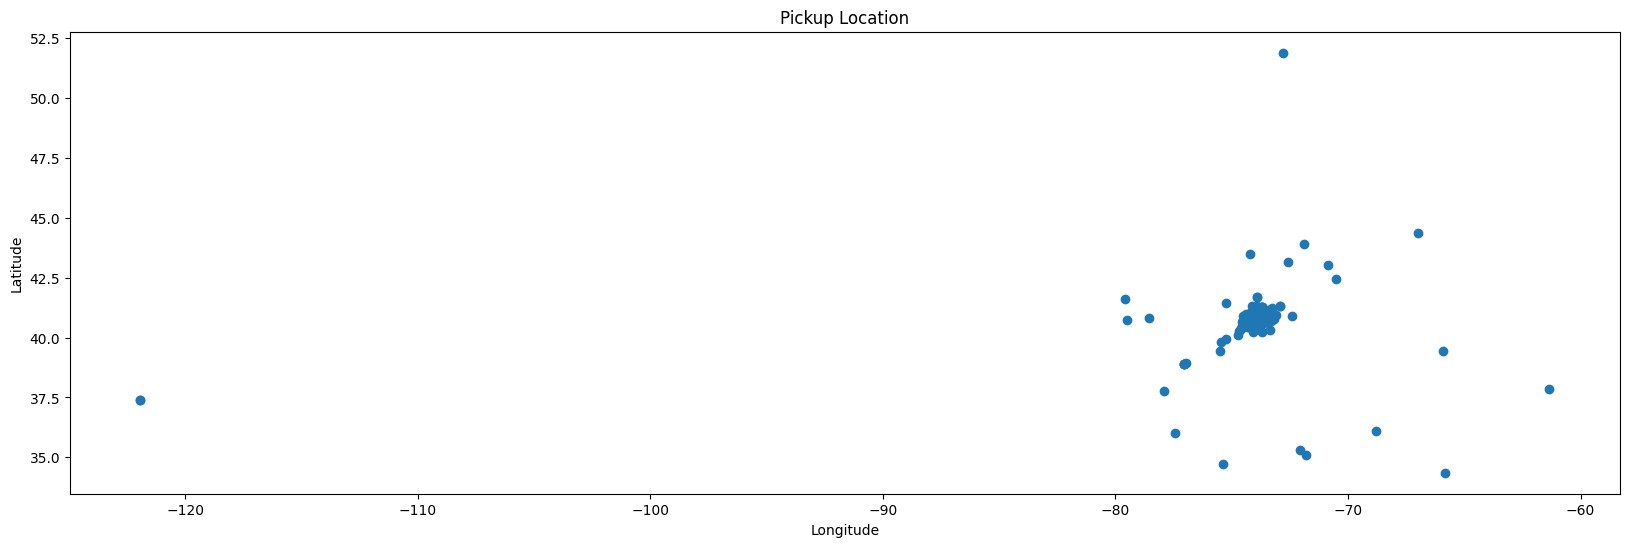

In [ ]:
# Plot the pickup and dropoff locations
plt.figure(figsize=(20, 6))
plt.scatter(df['pickup_longitude'] ,df['pickup_latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup Location')


In [ ]:
#get unique dropoff locations
unique_combinations_2 = df[['dropoff_longitude', 'dropoff_latitude']].drop_duplicates()
unique_combinations_2

,dropoff_longitude,dropoff_latitude
0,-73.964630,40.765602
1,-73.999481,40.731152
2,-74.005333,40.710087
3,-74.012268,40.706718
4,-73.972923,40.782520
...,...,...
1458639,-73.994911,40.740170
1458640,-73.970184,40.796547
1458641,-74.004433,40.707371
1458642,-73.974632,40.757107


Text(0.5, 1.0, 'Dropoff Location')

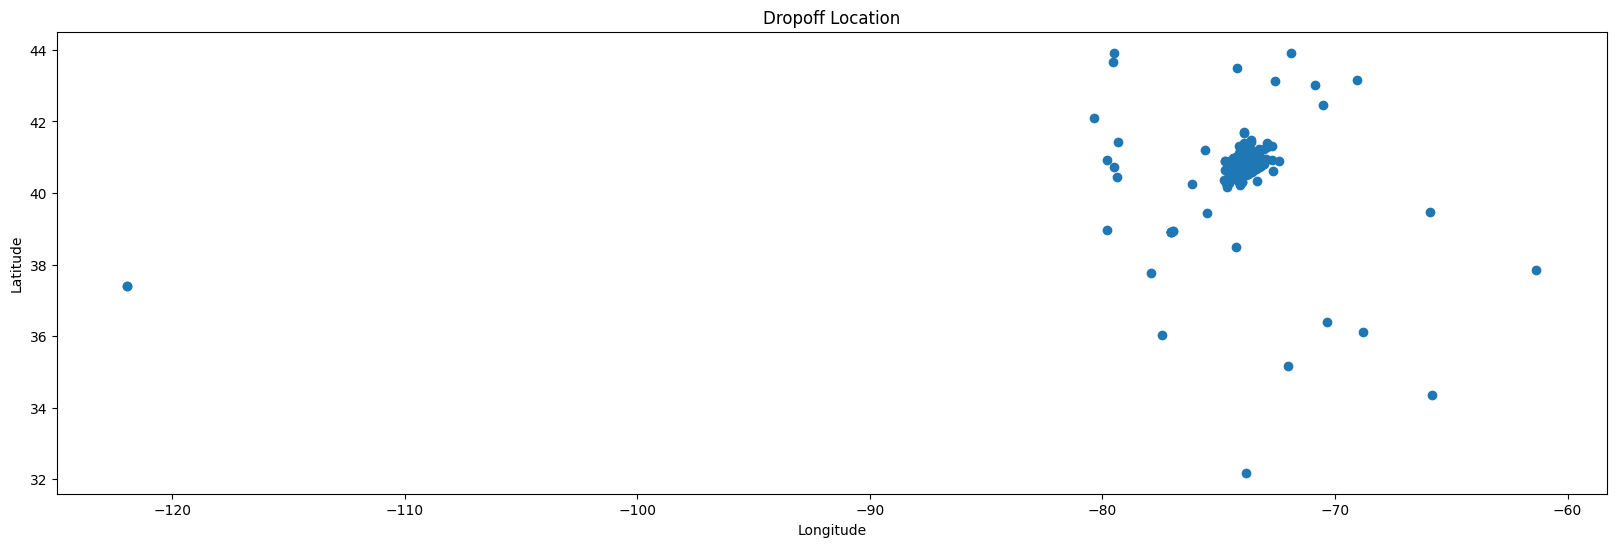

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(df['dropoff_longitude'] ,df['dropoff_latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dropoff Location')


In [ ]:
# Convert pickup and dropoff datetime to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Extract pickup and dropoff time
df['pickup_time'] = df['pickup_datetime'].dt.time
df['dropoff_time'] = df['dropoff_datetime'].dt.time


In [ ]:
# Create a DataFrame to store time and day information
df1 = pd.DataFrame(columns=['time'])
df2 = pd.DataFrame(columns=['time'])
df1.time=df['pickup_datetime'].dt.time
df2.time=df['dropoff_datetime'].dt.time

# Extract the day of the week from pickup datetime
df1['Day']=df['pickup_datetime'].dt.day_name()


In [ ]:
df1

,time,Day
0,17:24:55,Monday
1,00:43:35,Sunday
2,11:35:24,Tuesday
3,19:32:31,Wednesday
4,13:30:55,Saturday
...,...,...
1458639,13:31:04,Friday
1458640,07:35:15,Sunday
1458641,06:57:41,Friday
1458642,15:56:26,Tuesday


<Axes: title={'center': 'Bussiest Day'}, xlabel='Day', ylabel='No pickups'>

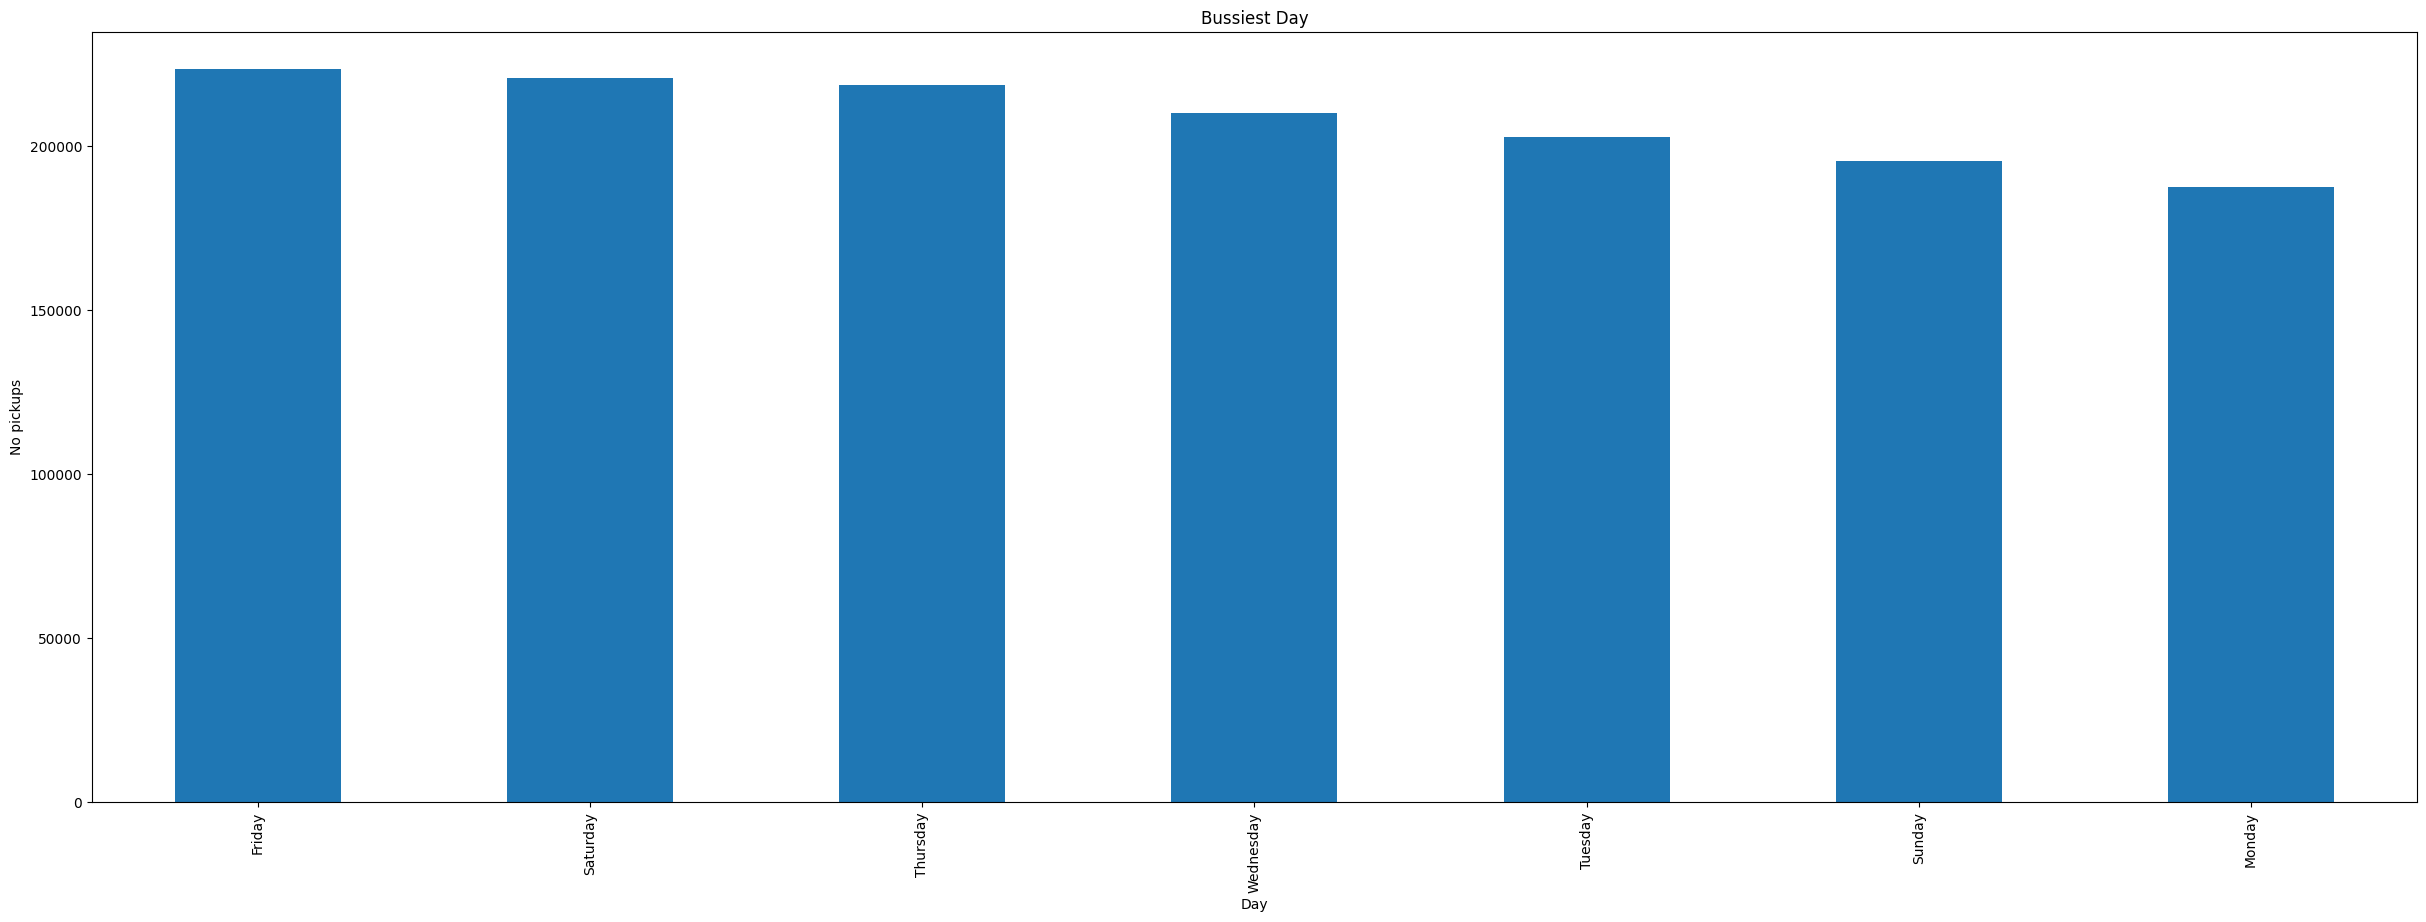

In [ ]:
# Plot the number of pickups for each day of the week
df1['Day'].value_counts().plot(kind='bar',figsize=(30,10),title='Bussiest Day',xlabel='Day',ylabel='No pickups')

In [ ]:
# Append pickup and dropoff time data to df1
df1=df1. append(df2, ignore_index=True)
#df1.time= str(df1.time)
df1

<ipython-input-15-f877aa41b61d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1=df1. append(df2, ignore_index=True)


,time,Day
0,17:24:55,Monday
1,00:43:35,Sunday
2,11:35:24,Tuesday
3,19:32:31,Wednesday
4,13:30:55,Saturday
...,...,...
2917283,13:44:02,NaN
2917284,07:46:10,NaN
2917285,07:10:25,NaN
2917286,16:02:39,NaN


In [ ]:
# Convert time to hours
df1.time = df1.time.apply(lambda x: x.hour)
df1

,time,Day
0,17,Monday
1,0,Sunday
2,11,Tuesday
3,19,Wednesday
4,13,Saturday
...,...,...
2917283,13,NaN
2917284,7,NaN
2917285,7,NaN
2917286,16,NaN


<Axes: title={'center': 'Bussiest Hour'}, xlabel='Time', ylabel='No pickups/dropoffs'>

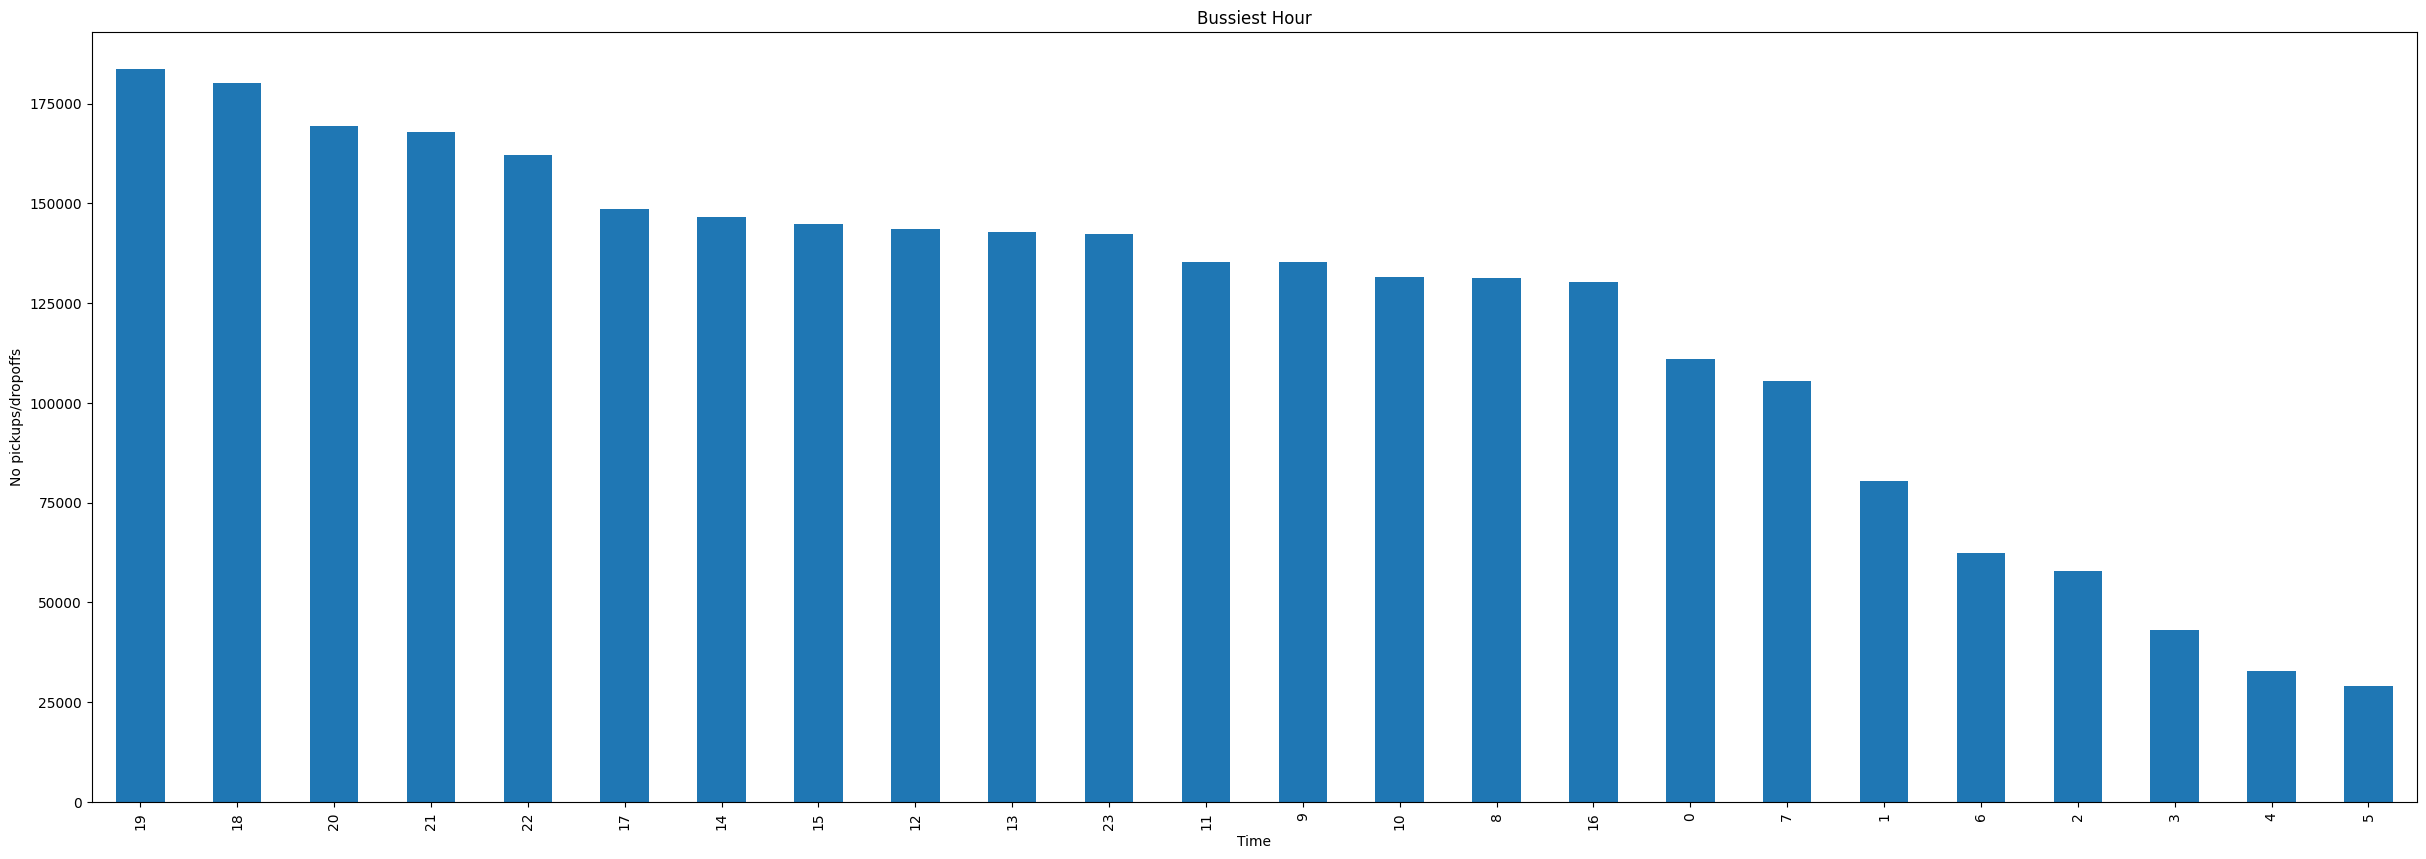

In [ ]:
# Plot the number of pickups for each hour of the day
df1.time.value_counts().plot(kind='bar',figsize=(30,10),title='Bussiest Hour',xlabel='Time',ylabel='No pickups/dropoffs')

In [ ]:
# Plot the average trip duration for each day of the week
df['Day']=df['pickup_datetime'].dt.day_name()

<Axes: title={'center': 'Trip Duration Day Wise'}, xlabel='Day', ylabel='Time in sec'>

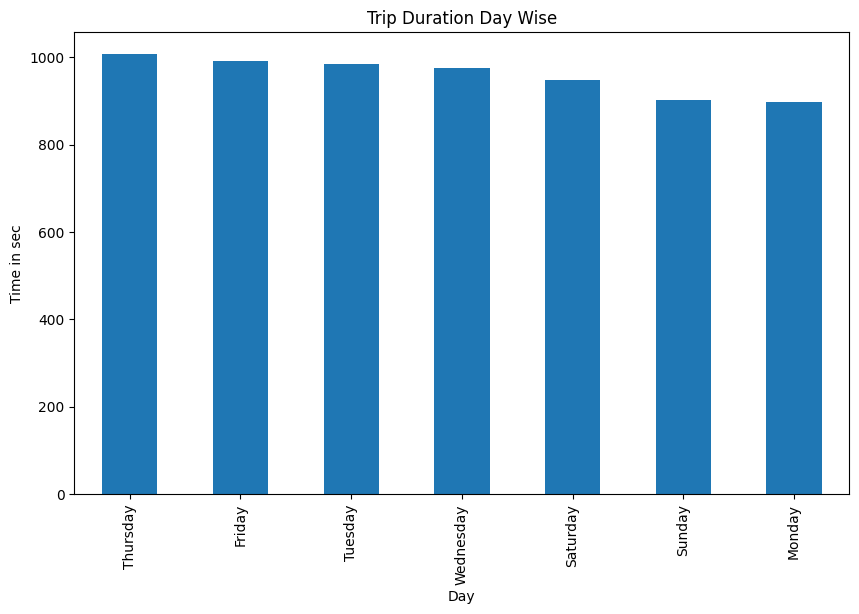

In [ ]:
#df.groupby('Day')['trip_duration'].mean().sort_values(ascending=False).plot(kind='bar', xlabel='Day', ylabel='Time in sec', figsize=(10, 6),title='Trip Duration Day Wise')
df.groupby('Day')['trip_duration'].mean().sort_values(ascending=False).plot(kind='bar', xlabel='Day', ylabel='Time in sec', figsize=(10, 6), title='Trip Duration Day Wise')


Text(0, 0.5, 'Time')

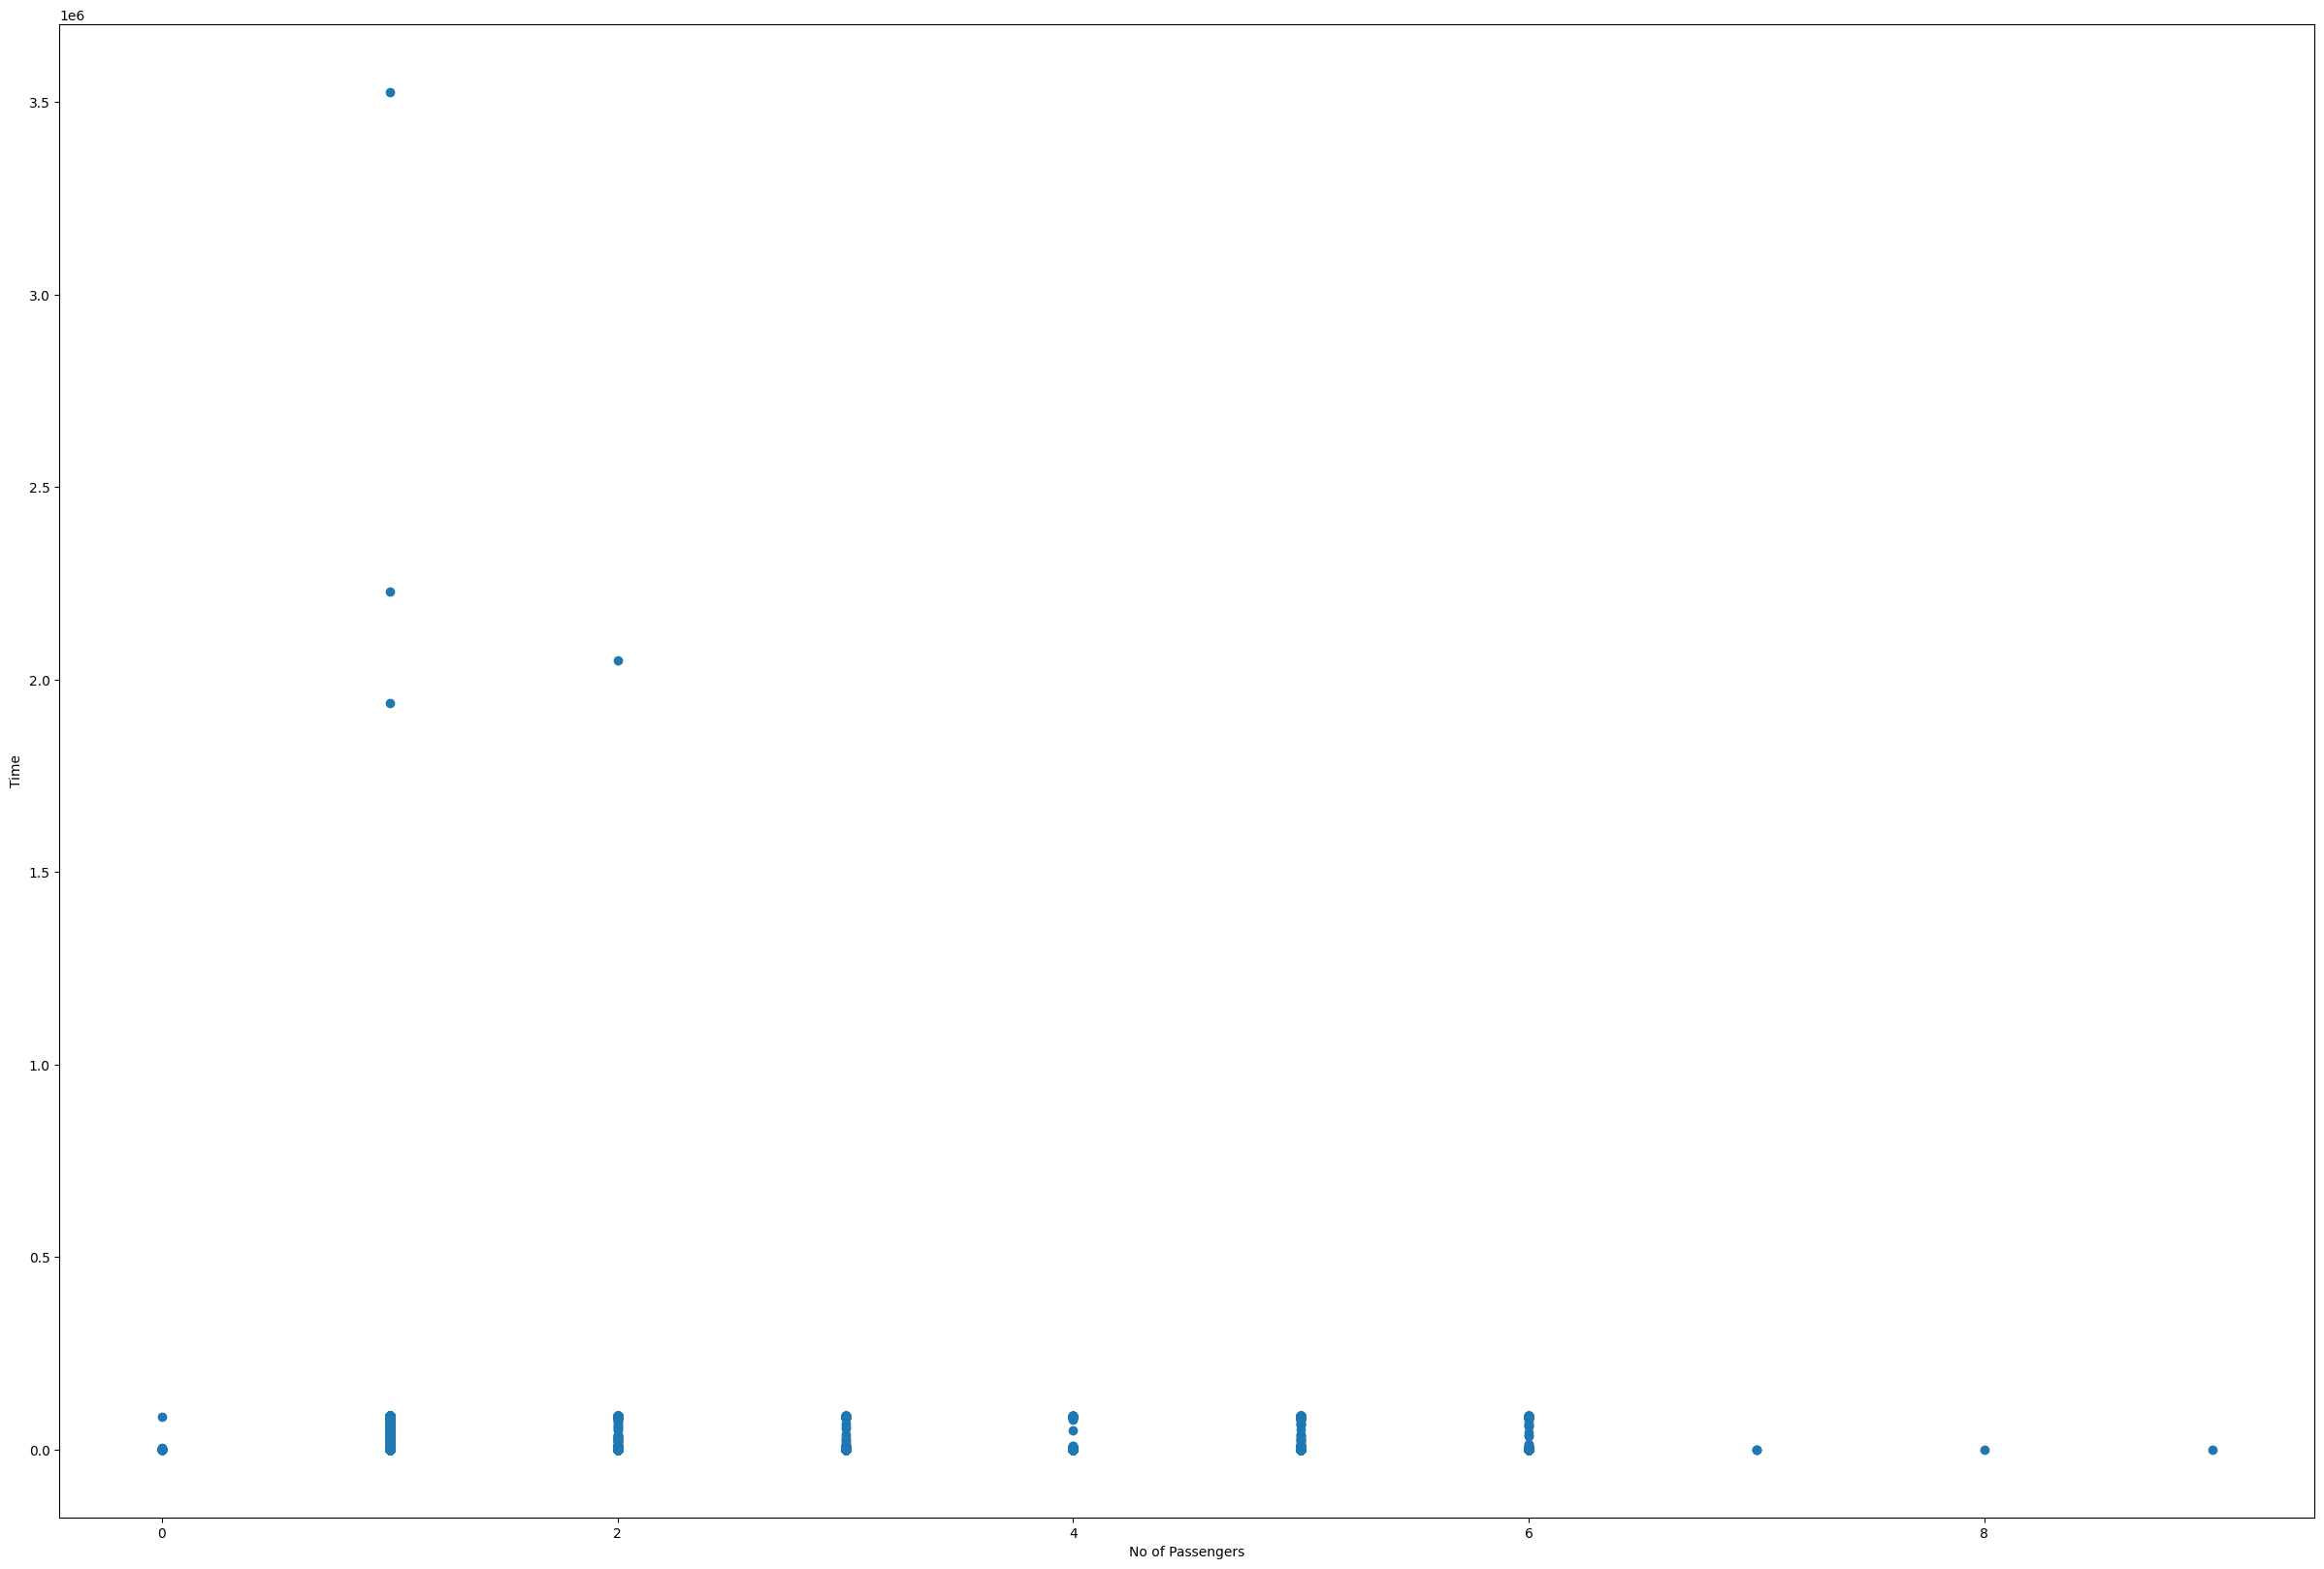

In [ ]:
plt.figure(figsize=(30,20))
plt.scatter(df.passenger_count,df.trip_duration)
plt.xlabel('No of Passengers')
plt.ylabel('Time')

In [ ]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_time,dropoff_time,Day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17:24:55,17:32:30,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,00:43:35,00:54:38,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11:35:24,12:10:48,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19:32:31,19:39:40,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13:30:55,13:38:10,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,13:31:04,13:44:02,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,07:35:15,07:46:10,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,06:57:41,07:10:25,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,15:56:26,16:02:39,Tuesday


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_time         1458644 non-null  object        
 12  dropoff_time        1458644 non-null  object        
 13  Day         

In [ ]:
def haversine_distance(row):
    R = 6371.0  # Radius of the Earth in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']])

    # Calculate differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Calculate distance
    distance = R * c

    return distance

# Apply the haversine_distance function to create a new column 'distance_km'
df['distance_km'] = df.apply(haversine_distance, axis=1)

In [ ]:


# Extract relevant datetime components for pickup datetime
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['pickup_second'] = df['pickup_datetime'].dt.second

# Extract relevant datetime components for dropoff datetime
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_minute'] = df['dropoff_datetime'].dt.minute
df['dropoff_second'] = df['dropoff_datetime'].dt.second

# Drop unnecessary columns
df = df.drop(columns=['pickup_datetime', 'dropoff_datetime','pickup_time',	'dropoff_time'	])



In [ ]:
df

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Day,distance_km,pickup_hour,pickup_minute,pickup_second,dropoff_hour,dropoff_minute,dropoff_second
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,1.498521,17,24,55,17,32,30
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,1.805507,0,43,35,0,54,38
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,6.385098,11,35,24,12,10,48
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,1.485498,19,32,31,19,39,40
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,1.188588,13,30,55,13,38,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,4,-73.982201,40.745522,-73.994911,40.740170,N,778,Friday,1.225080,13,31,4,13,44,2
1458640,id1049543,1,1,-74.000946,40.747379,-73.970184,40.796547,N,655,Sunday,6.049836,7,35,15,7,46,10
1458641,id2304944,2,1,-73.959129,40.768799,-74.004433,40.707371,N,764,Friday,7.824606,6,57,41,7,10,25
1458642,id2714485,1,1,-73.982079,40.749062,-73.974632,40.757107,N,373,Tuesday,1.092564,15,56,26,16,2,39


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   passenger_count     1458644 non-null  int64  
 3   pickup_longitude    1458644 non-null  float64
 4   pickup_latitude     1458644 non-null  float64
 5   dropoff_longitude   1458644 non-null  float64
 6   dropoff_latitude    1458644 non-null  float64
 7   store_and_fwd_flag  1458644 non-null  object 
 8   trip_duration       1458644 non-null  int64  
 9   Day                 1458644 non-null  object 
 10  distance_km         1458644 non-null  float64
 11  pickup_hour         1458644 non-null  int64  
 12  pickup_minute       1458644 non-null  int64  
 13  pickup_second       1458644 non-null  int64  
 14  dropoff_hour        1458644 non-null  int64  
 15  dropoff_minute 

In [ ]:
df = df.drop(columns=['id'	])


In [ ]:
df

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Day,distance_km,pickup_hour,pickup_minute,pickup_second,dropoff_hour,dropoff_minute,dropoff_second
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,1.498521,17,24,55,17,32,30
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,1.805507,0,43,35,0,54,38
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,6.385098,11,35,24,12,10,48
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,1.485498,19,32,31,19,39,40
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,1.188588,13,30,55,13,38,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2,4,-73.982201,40.745522,-73.994911,40.740170,N,778,Friday,1.225080,13,31,4,13,44,2
1458640,1,1,-74.000946,40.747379,-73.970184,40.796547,N,655,Sunday,6.049836,7,35,15,7,46,10
1458641,2,1,-73.959129,40.768799,-74.004433,40.707371,N,764,Friday,7.824606,6,57,41,7,10,25
1458642,1,1,-73.982079,40.749062,-73.974632,40.757107,N,373,Tuesday,1.092564,15,56,26,16,2,39


In [ ]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['Day', 'store_and_fwd_flag'],drop_first=True)


In [ ]:
df_encoded

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance_km,pickup_hour,pickup_minute,...,dropoff_hour,dropoff_minute,dropoff_second,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,store_and_fwd_flag_Y
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,1.498521,17,24,...,17,32,30,1,0,0,0,0,0,0
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,1.805507,0,43,...,0,54,38,0,0,1,0,0,0,0
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,6.385098,11,35,...,12,10,48,0,0,0,0,1,0,0
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,1.485498,19,32,...,19,39,40,0,0,0,0,0,1,0
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,1.188588,13,30,...,13,38,10,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2,4,-73.982201,40.745522,-73.994911,40.740170,778,1.225080,13,31,...,13,44,2,0,0,0,0,0,0,0
1458640,1,1,-74.000946,40.747379,-73.970184,40.796547,655,6.049836,7,35,...,7,46,10,0,0,1,0,0,0,0
1458641,2,1,-73.959129,40.768799,-74.004433,40.707371,764,7.824606,6,57,...,7,10,25,0,0,0,0,0,0,0
1458642,1,1,-73.982079,40.749062,-73.974632,40.757107,373,1.092564,15,56,...,16,2,39,0,0,0,0,1,0,0


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vendor_id             1458644 non-null  int64  
 1   passenger_count       1458644 non-null  int64  
 2   pickup_longitude      1458644 non-null  float64
 3   pickup_latitude       1458644 non-null  float64
 4   dropoff_longitude     1458644 non-null  float64
 5   dropoff_latitude      1458644 non-null  float64
 6   trip_duration         1458644 non-null  int64  
 7   distance_km           1458644 non-null  float64
 8   pickup_hour           1458644 non-null  int64  
 9   pickup_minute         1458644 non-null  int64  
 10  pickup_second         1458644 non-null  int64  
 11  dropoff_hour          1458644 non-null  int64  
 12  dropoff_minute        1458644 non-null  int64  
 13  dropoff_second        1458644 non-null  int64  
 14  Day_Monday            1458644 non-

In [ ]:
numerical_columns = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'distance_km', 'pickup_hour', 'pickup_minute', 'pickup_second', 'dropoff_hour', 'dropoff_minute', 'dropoff_second']

# Remove outliers from numerical columns
df_encoded = remove_outliers_iqr(df_encoded, columns=numerical_columns)

In [ ]:
df_Independent=df_encoded
df_Independent1=df_Independent.drop(columns=['trip_duration'])




In [ ]:
df_Independent1

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_km,pickup_hour,pickup_minute,pickup_second,dropoff_hour,dropoff_minute,dropoff_second,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,store_and_fwd_flag_Y
0,2,1,-73.982155,40.767937,-73.964630,40.765602,1.498521,17,24,55,17,32,30,1,0,0,0,0,0,0
1,1,1,-73.980415,40.738564,-73.999481,40.731152,1.805507,0,43,35,0,54,38,0,0,1,0,0,0,0
3,2,1,-74.010040,40.719971,-74.012268,40.706718,1.485498,19,32,31,19,39,40,0,0,0,0,0,1,0
4,2,1,-73.973053,40.793209,-73.972923,40.782520,1.188588,13,30,55,13,38,10,0,1,0,0,0,0,0
7,2,1,-73.969276,40.797779,-73.922470,40.760559,5.714981,7,54,58,8,20,49,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458637,1,1,-73.975357,40.751705,-73.949478,40.776764,3.537555,18,48,16,19,0,56,0,0,1,0,0,0,0
1458640,1,1,-74.000946,40.747379,-73.970184,40.796547,6.049836,7,35,15,7,46,10,0,0,1,0,0,0,0
1458641,2,1,-73.959129,40.768799,-74.004433,40.707371,7.824606,6,57,41,7,10,25,0,0,0,0,0,0,0
1458642,1,1,-73.982079,40.749062,-73.974632,40.757107,1.092564,15,56,26,16,2,39,0,0,0,0,1,0,0


In [ ]:
# Calculate VIF for each independent variable
def calculate_vif(data):
  vif_data =pd.DataFrame()
  vif_data["Variable"] = data.columns
  vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  return(vif_data)

In [ ]:
calculate_vif(df_Independent1)

,Variable,VIF
0,vendor_id,9.992002e+00
1,passenger_count,6.683997e+00
2,pickup_longitude,2.627185e+07
3,pickup_latitude,6.754774e+06
4,dropoff_longitude,2.666970e+07
5,dropoff_latitude,5.990928e+06
6,distance_km,3.321887e+00
7,pickup_hour,5.972512e+01
8,pickup_minute,4.043849e+00
9,pickup_second,3.895499e+00


In [ ]:

df1=df_Independent1.drop(columns=['pickup_longitude',	'pickup_latitude',	'dropoff_longitude',	'dropoff_latitude'])

In [ ]:
calculate_vif(df1)

,Variable,VIF
0,vendor_id,7.965102
1,passenger_count,5.966294
2,distance_km,3.058098
3,pickup_hour,59.435710
4,pickup_minute,3.807996
5,pickup_second,3.593223
6,dropoff_hour,58.613846
7,dropoff_minute,3.780983
8,dropoff_second,3.605424
9,Day_Monday,1.694769


In [ ]:
df1=df1.drop(columns=['pickup_hour',	'dropoff_hour','vendor_id'])

In [ ]:
calculate_vif(df1)

,Variable,VIF
0,passenger_count,5.158312
1,distance_km,2.968926
2,pickup_minute,3.698538
3,pickup_second,3.443078
4,dropoff_minute,3.673827
5,dropoff_second,3.456134
6,Day_Monday,1.614819
7,Day_Saturday,1.764993
8,Day_Sunday,1.649720
9,Day_Thursday,1.715805


In [ ]:
from sklearn.preprocessing import MinMaxScaler,RobustScaler


In [ ]:
# Scale the independent variables
df1 = pd.DataFrame(MinMaxScaler().fit_transform(df1), columns=df1.columns)
df1


,passenger_count,distance_km,pickup_minute,pickup_second,dropoff_minute,dropoff_second,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,store_and_fwd_flag_Y
0,0.333333,0.191124,0.406780,0.932203,0.542373,0.508475,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.333333,0.230278,0.728814,0.593220,0.915254,0.644068,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.333333,0.189463,0.542373,0.525424,0.661017,0.677966,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.333333,0.151595,0.508475,0.932203,0.644068,0.169492,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.333333,0.728900,0.915254,0.983051,0.338983,0.830508,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105577,0.333333,0.451187,0.813559,0.271186,0.000000,0.949153,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1105578,0.333333,0.771608,0.593220,0.254237,0.779661,0.169492,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1105579,0.333333,0.997966,0.966102,0.694915,0.169492,0.423729,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1105580,0.333333,0.139348,0.949153,0.440678,0.033898,0.661017,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Split the data into training and testing sets
X= df1
y=df_encoded['trip_duration']/60
y

0           7.583333
1          11.050000
3           7.150000
4           7.250000
7          25.850000
             ...    
1458637    12.666667
1458640    10.916667
1458641    12.733333
1458642     6.216667
1458643     3.300000
Name: trip_duration, Length: 1105582, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)


#LinearRegression

In [ ]:

model = LinearRegression()
# Train the model
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse,r2

(23.024098584696617, 0.48454980908237666)

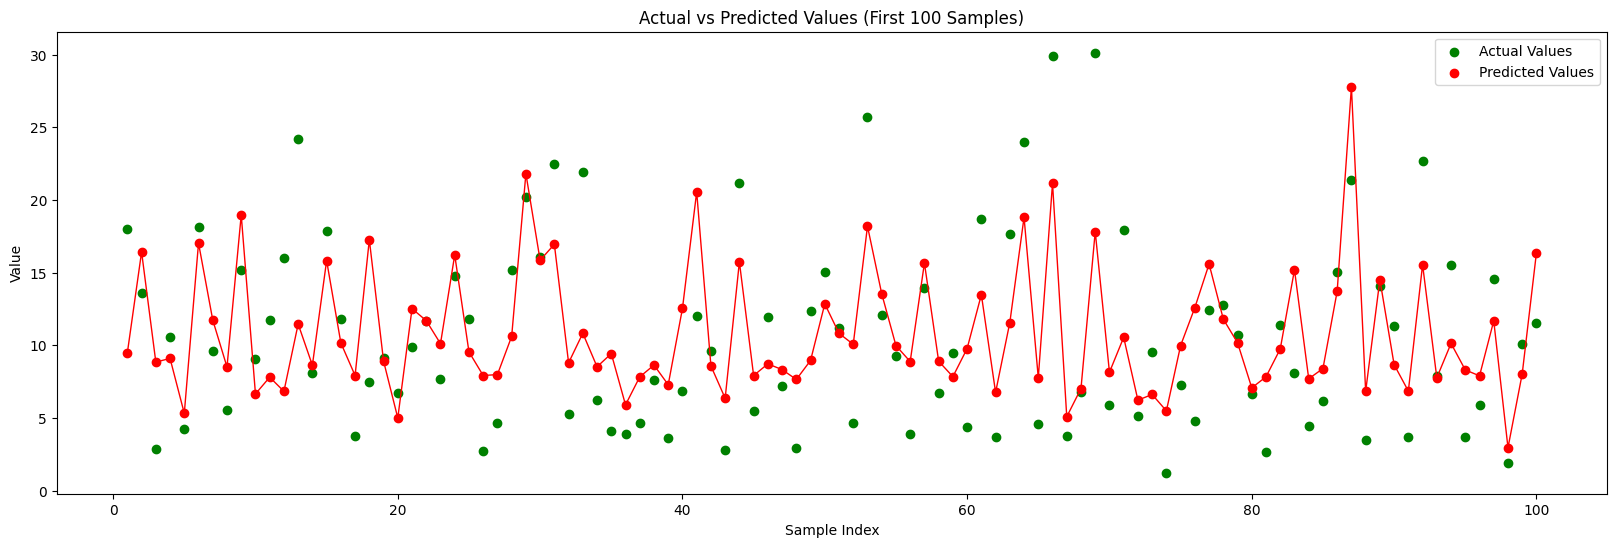

In [ ]:
actual_values = y_test[:100]
predicted_values = y_pred[:100]
plt.figure(figsize=(20, 6))
# Create a scatter plot
plt.scatter(range(1, 101), actual_values, color='g', label='Actual Values')
plt.scatter(range(1, 101), predicted_values, color='red', label='Predicted Values')
plt.plot(range(1,101),predicted_values, color = 'r', linewidth=1)
# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (First 100 Samples)')
plt.legend()

#Lasso

In [ ]:
model = Lasso(0.01)
# Train the model
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse,r2

(23.038576023463264, 0.48422569656397274)

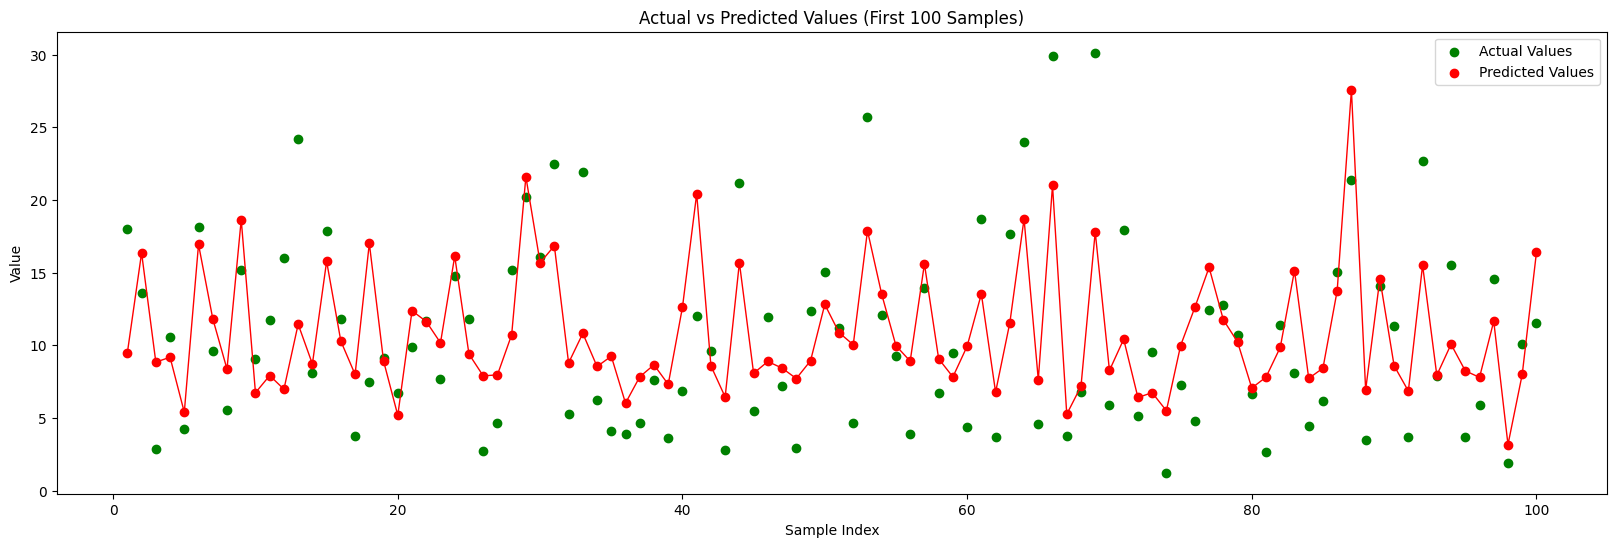

In [ ]:
actual_values = y_test[:100]
predicted_values = y_pred[:100]
plt.figure(figsize=(20, 6))
# Create a scatter plot
plt.scatter(range(1, 101), actual_values, color='g', label='Actual Values')
plt.scatter(range(1, 101), predicted_values, color='red', label='Predicted Values')
plt.plot(range(1,101),predicted_values, color = 'r', linewidth=1)
# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (First 100 Samples)')
plt.legend()

# Ridge

In [ ]:
model = Ridge(0.01)
# Train the model
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse,r2

(23.024098554032864, 0.4845498097688591)

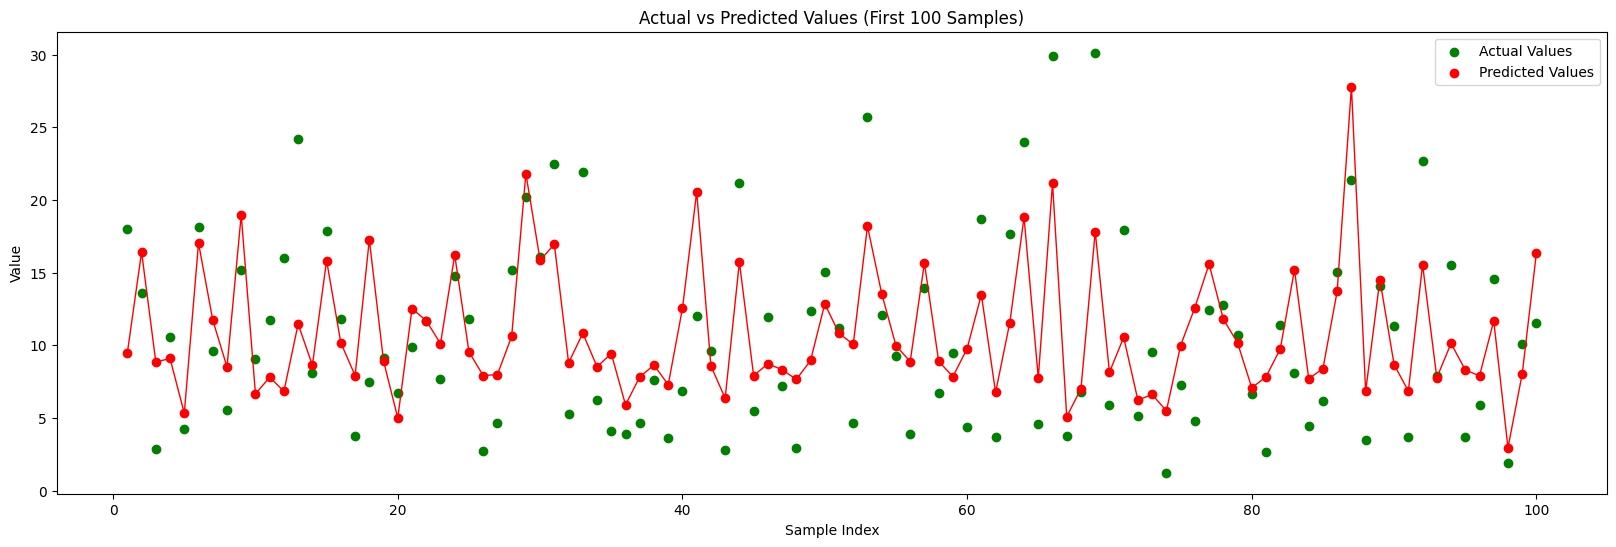

In [ ]:
actual_values = y_test[:100]
predicted_values = y_pred[:100]
plt.figure(figsize=(20, 6))
# Create a scatter plot
plt.scatter(range(1, 101), actual_values, color='g', label='Actual Values')
plt.scatter(range(1, 101), predicted_values, color='red', label='Predicted Values')
plt.plot(range(1,101),predicted_values, color = 'r', linewidth=1)
# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (First 100 Samples)')
plt.legend()

# ElasticNet



In [ ]:
alpha = 0.1  # Regularization strength
l1_ratio = 0.5  # Mixing parameter (0: L2 penalty, 1: L1 penalty)
elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

# Train the model
elastic_net_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = elastic_net_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse,r2

(30.916144651809272, 0.3078672502816714)

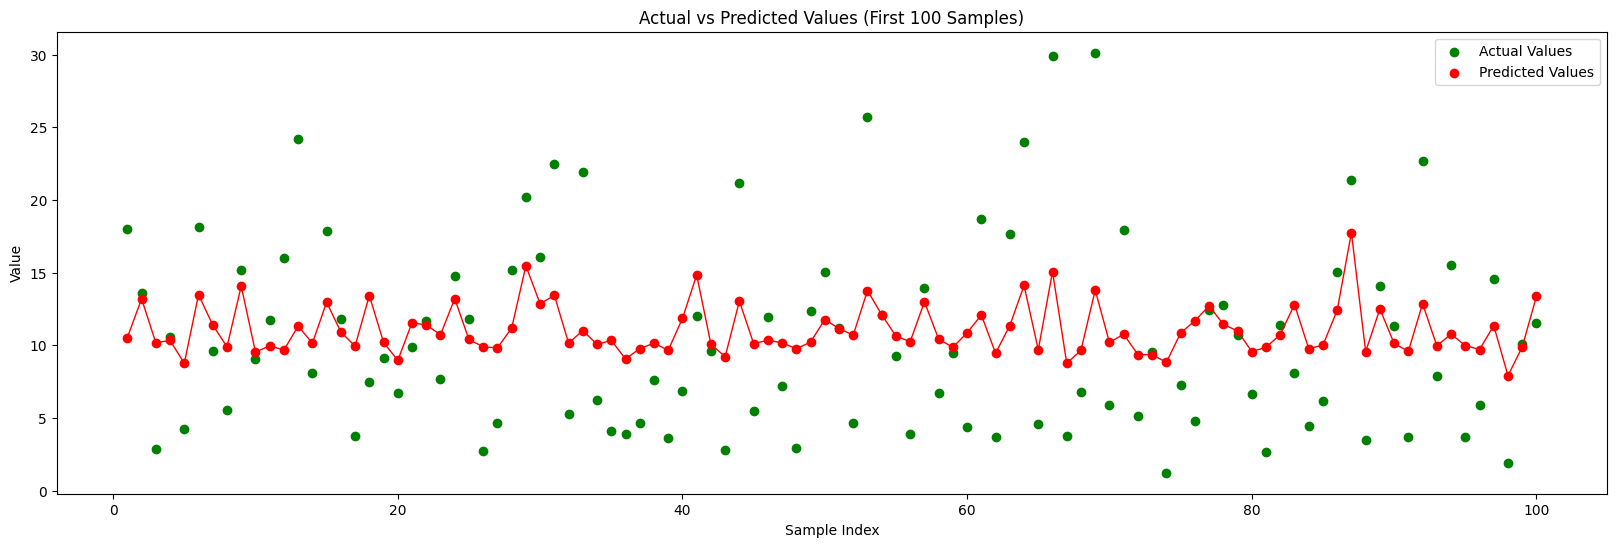

In [ ]:
actual_values = y_test[:100]
predicted_values = y_pred[:100]
plt.figure(figsize=(20, 6))
# Create a scatter plot
plt.scatter(range(1, 101), actual_values, color='g', label='Actual Values')
plt.scatter(range(1, 101), predicted_values, color='red', label='Predicted Values')
plt.plot(range(1,101),predicted_values, color = 'r', linewidth=1)
# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (First 100 Samples)')
plt.legend()

In [ ]:
#optimising our models

linear_reg_model = LinearRegression()
linear_reg_param_grid = {}

# Ridge Regression
ridge_model = Ridge()
ridge_param_grid = {'alpha': [0.1, 1, 10]}

# Lasso Regression
lasso_model = Lasso()
lasso_param_grid = {'alpha': [0.1, 1, 10]}

# Models and parameter grids
models = [linear_reg_model, ridge_model, lasso_model]
param_grids = [linear_reg_param_grid, ridge_param_grid, lasso_param_grid]

# Loop through models and parameter grids
for model, param_grid in zip(models, param_grids):
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

    # Fit the model to the data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and the corresponding score
    print(f"Best Parameters for {model.__class__.__name__}:", grid_search.best_params_)
    print(f"Best Score (MSE) for {model.__class__.__name__}:", -grid_search.best_score_)

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Test Set MSE for {model.__class__.__name__}:", mse)
    print()

Best Parameters for LinearRegression: {}
Best Score (MSE) for LinearRegression: 22.925462774494864
Test Set MSE for LinearRegression: 23.024098584696617

Best Parameters for Ridge: {'alpha': 1}
Best Score (MSE) for Ridge: 22.925462746850705
Test Set MSE for Ridge: 23.02409554503229

Best Parameters for Lasso: {'alpha': 0.1}
Best Score (MSE) for Lasso: 23.568458265679176
Test Set MSE for Lasso: 23.67540986492423



# VotingRegressor

In [ ]:
linear_reg = LinearRegression()
ridge_reg = Ridge(alpha=1)
lasso_reg = Lasso(alpha=0.1)

# Create the voting regressor
voting_regressor = VotingRegressor([
    ('linear', linear_reg),
    ('ridge', ridge_reg),
    ('lasso', lasso_reg)
])

# Train the voting regressor on the training data
voting_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = voting_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(23.098286321362398, 0.4828889369797208)

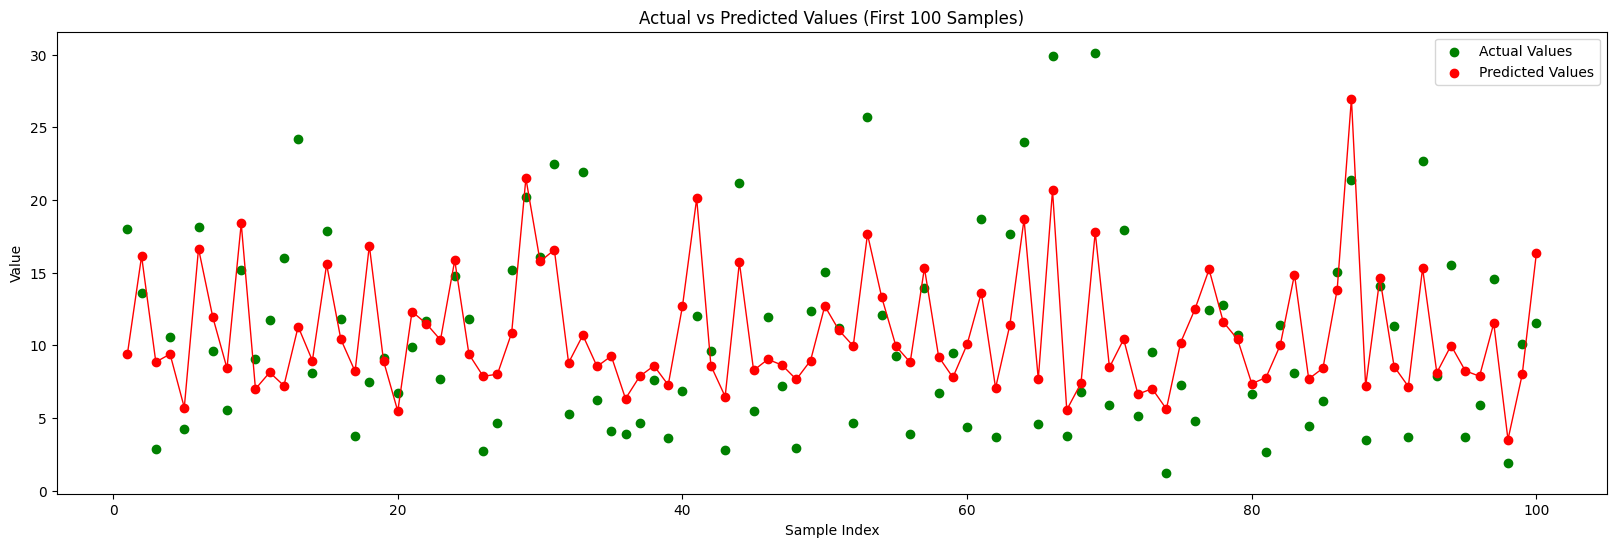

In [ ]:
actual_values = y_test[:100]
predicted_values = y_pred[:100]
plt.figure(figsize=(20, 6))
# Create a scatter plot
plt.scatter(range(1, 101), actual_values, color='g', label='Actual Values')
plt.scatter(range(1, 101), predicted_values, color='red', label='Predicted Values')
plt.plot(range(1,101),predicted_values, color = 'r', linewidth=1)
# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (First 100 Samples)')
plt.legend()


# **Conclusions:**


 - The Linear Regression model without regularization performed the best, with the lowest MSE and highest R2 score.
 - Regularization techniques like Ridge and Lasso did not significantly improve performance compared to Linear Regression.
 - The Elastic Net model also showed comparable performance to Linear Regression.
 - The Voting Regressor, which combined the predictions of Linear, Ridge, and Lasso models, achieved similar performance to the individual models.
 - The VIF analysis indicated that the pickup and dropoff locations, as well as the pickup and dropoff times, had the highest impact on trip duration.
 - Passenger count, distance, and vendor ID also showed some influence on trip duration.
 - Removing outliers from the numerical columns improved the model performance by reducing the influence of extreme values.
 - Min-max scaling the independent variables helped to ensure that all features had a similar scale and contributed equally to the model.

 - Additional features could also be added to the model to improve its accuracy, such as weather data or traffic conditions.


